In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))

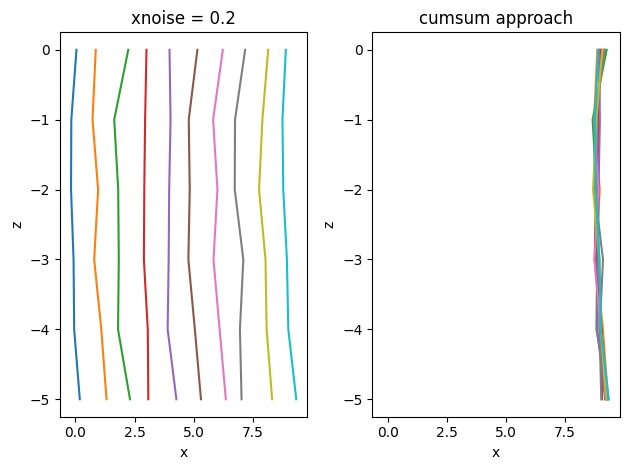

,theta,i,j,Error
Day,,,,
0,0.0,9.005022,-4.434595e-08,1.232459
1,0.0,8.003195,-3.939103e-08,1.111936
2,0.0,7.021786,-3.485110e-08,0.856813
3,0.0,5.975463,-2.972856e-08,0.591194
4,0.0,4.944723,-2.448362e-08,0.524026
5,0.0,3.970552,-1.936951e-08,0.374204
6,0.0,2.896674,-1.396715e-08,0.361345
7,0.0,1.997740,-9.808750e-09,0.143388
8,0.0,0.910328,-4.526945e-09,0.055570


In [15]:
z = np.arange(-5,1)

t_end = 10

noise = .2

df = pd.DataFrame({'x0':[0] * len(z), 'y0':[0] * len(z)})
for t in range(t_end):
    df['x'+str(t)] = df['x0'] + t + np.random.uniform(-noise, noise, size=len(df))
    df['y'+str(t)] = df['y0'] #+ np.random.uniform(-noise, noise, size=len(df))
df['z'] = z
df = df.set_index('z')

fig, axs = plt.subplots(1, 2)
for t in range(t_end):
    axs[0].plot(df['x'+str(t)], df.index)

best_shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
for t in range(t_end):
    if t == t_end-1:
        best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': 0, 'i': 0, 'j': 0, 'Error': 0}
    else:
        # Sample data 
        x_t1 = df['x'+str(t)] # x-coordinates at t1
        y_t1 = df['y'+str(t)]   # y-coordinates at t1
        x_t2 = df['x'+str(t+1)] # x-coordinates at t2
        y_t2 = df['y'+str(t+1)]   # y-coordinates at t2
    
        # Objective function
        def R(params):
            a, b, theta = params
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
            term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
            return np.sum(term1 + term2)
        
        # Initial guess for a, b, theta
        initial_guess = [0, 0, 0]
        
        # Optimize
        result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
        a_opt, b_opt, theta_opt = result.x
        error = R((a_opt, b_opt, theta_opt))
        theta_opt = np.rad2deg(theta_opt)

        best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}

best_shift_df = best_shift_df.set_index('Day')
best_shift_df = best_shift_df.iloc[::-1].cumsum().iloc[::-1]

df_shifted = df.copy()
for t in range(t_end):
    i = best_shift_df.loc[t]['i']
    j = best_shift_df.loc[t]['j']
    theta = best_shift_df.loc[t]['theta']

    x = df['x'+str(t)]
    y = df['y'+str(t)]

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j

    df_shifted['x'+str(t)] = x_shifted
    df_shifted['y'+str(t)] = y_shifted

axs[0].set_title('xnoise = '+str(noise))
axs[1].set_title('cumsum approach')

for t in range(t_end):
    axs[1].plot(df_shifted['x'+str(t)], df.index)

xmin = 0
xmax = 0
for ax in axs:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs:
    ax.set_xlim(xmin, xmax)

axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')

plt.tight_layout()
plt.show()

best_shift_df

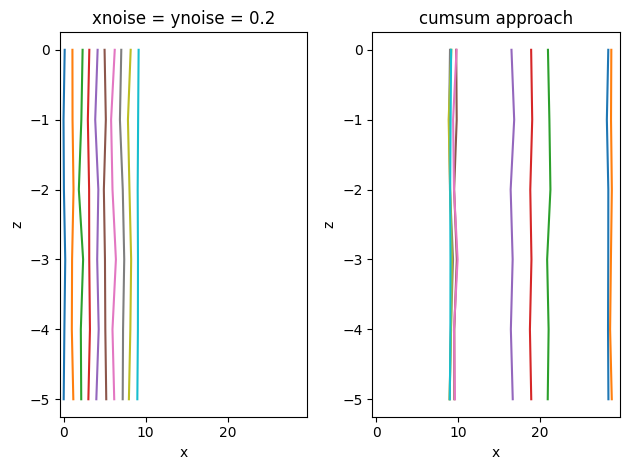

,theta,i,j,Error
Day,,,,
0,324.564428,28.204473,6.206990,2.391345
1,324.564428,27.182805,5.220515,2.190179
2,160.498278,23.714473,2.528198,1.806796
3,160.498278,22.782313,1.562126,1.456523
4,160.498278,21.775729,0.499068,1.331693
5,69.345416,12.587204,-0.529892,1.076266
6,25.215426,6.637570,0.690511,0.795974
7,25.215426,5.560053,-0.384729,0.528245
8,0.000000,0.998517,0.970336,0.193735


In [16]:
z = np.arange(-5,1)

t_end = 10

noise = .2

df = pd.DataFrame({'x0':[0] * len(z), 'y0':[0] * len(z)})
for t in range(t_end):
    df['x'+str(t)] = df['x0'] + t + np.random.uniform(-noise, noise, size=len(df))
    df['y'+str(t)] = df['y0'] + t + np.random.uniform(-noise, noise, size=len(df))
df['z'] = z
df = df.set_index('z')

fig, axs = plt.subplots(1, 2)
for t in range(t_end):
    axs[0].plot(df['x'+str(t)], df.index)

best_shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
for t in range(t_end):
    if t == t_end-1:
        best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': 0, 'i': 0, 'j': 0, 'Error': 0}
    else:
        # Sample data 
        x_t1 = df['x'+str(t)] # x-coordinates at t1
        y_t1 = df['y'+str(t)]   # y-coordinates at t1
        x_t2 = df['x'+str(t+1)] # x-coordinates at t2
        y_t2 = df['y'+str(t+1)]   # y-coordinates at t2
    
        # Objective function
        def R(params):
            a, b, theta = params
            cos_theta = np.cos(theta)
            sin_theta = np.sin(theta)
            term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
            term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
            return np.sum(term1 + term2)
        
        # Initial guess for a, b, theta
        initial_guess = [0, 0, 0]
        
        # Optimize
        result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
        a_opt, b_opt, theta_opt = result.x
        error = R((a_opt, b_opt, theta_opt))
        theta_opt = np.rad2deg(theta_opt)

        best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}

best_shift_df = best_shift_df.set_index('Day')
best_shift_df = best_shift_df.iloc[::-1].cumsum().iloc[::-1]

df_shifted = df.copy()
for t in range(t_end):
    i = best_shift_df.loc[t]['i']
    j = best_shift_df.loc[t]['j']
    theta = best_shift_df.loc[t]['theta']

    x = df['x'+str(t)]
    y = df['y'+str(t)]

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j

    df_shifted['x'+str(t)] = x_shifted
    df_shifted['y'+str(t)] = y_shifted

axs[0].set_title('xnoise = ynoise = '+str(noise))
axs[1].set_title('cumsum approach')

for t in range(t_end):
    axs[1].plot(df_shifted['x'+str(t)], df.index)

xmin = 0
xmax = 0
for ax in axs:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs:
    ax.set_xlim(xmin, xmax)

axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')

plt.tight_layout()
plt.show()

best_shift_df

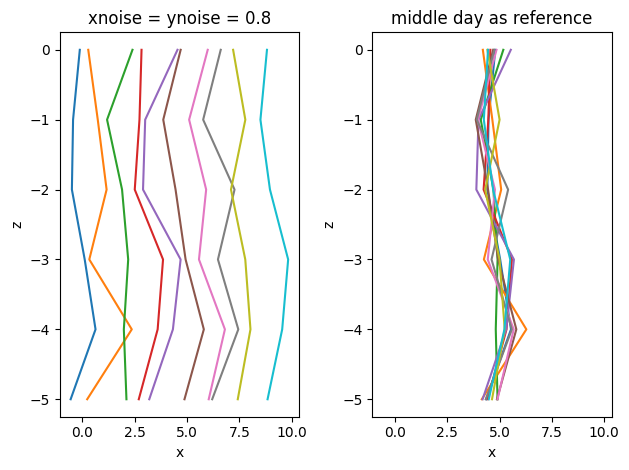

,theta,i,j,Error
Day,,,,
0,0.000000,4.917131,4.702050,1.300935
1,0.000000,3.920382,3.678000,4.265992
2,6.289212,3.027628,2.830375,1.596655
3,0.000000,1.736512,1.720120,2.991386
4,0.000000,0.994229,0.879753,2.675059
5,0.000000,0.000000,0.000000,0.000000
6,0.000000,-1.132220,-0.935494,1.804107
7,0.000000,-1.858781,-2.439476,3.069657
8,0.000000,-2.782534,-3.283196,3.255628


In [14]:
z = np.arange(-5,1)

t_end = 10

noise = .8

df = pd.DataFrame({'x0':[0] * len(z), 'y0':[0] * len(z)})
for t in range(t_end):
    df['x'+str(t)] = df['x0'] + t + np.random.uniform(-noise, noise, size=len(df))
    df['y'+str(t)] = df['y0'] + t + np.random.uniform(-noise, noise, size=len(df))
df['z'] = z
df = df.set_index('z')

fig, axs = plt.subplots(1, 2)
for t in range(t_end):
    axs[0].plot(df['x'+str(t)], df.index)

best_shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
for t in range(t_end):

    # Sample data 
    x_t1 = df['x'+str(t)] # x-coordinates at t1
    y_t1 = df['y'+str(t)]   # y-coordinates at t1
    x_t2 = df['x'+str(t_end//2)] # x-coordinates at t2
    y_t2 = df['y'+str(t_end//2)]   # y-coordinates at t2

    # Objective function
    def R(params):
        a, b, theta = params
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
        term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
        return np.sum(term1 + term2)
    
    # Initial guess for a, b, theta
    initial_guess = [0, 0, 0]
    
    # Optimize
    result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
    a_opt, b_opt, theta_opt = result.x
    error = R((a_opt, b_opt, theta_opt))
    theta_opt = np.rad2deg(theta_opt)

    best_shift_df.loc[len(best_shift_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}

best_shift_df = best_shift_df.set_index('Day')

df_shifted = df.copy()
for t in range(t_end):
    i = best_shift_df.loc[t]['i']
    j = best_shift_df.loc[t]['j']
    theta = best_shift_df.loc[t]['theta']

    x = df['x'+str(t)]
    y = df['y'+str(t)]

    points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
    x_shifted = points_rotated[:, 0] + i
    y_shifted = points_rotated[:, 1] + j

    df_shifted['x'+str(t)] = x_shifted
    df_shifted['y'+str(t)] = y_shifted
    
axs[0].set_title('xnoise = ynoise = '+str(noise))
axs[1].set_title('middle day as reference')

for t in range(t_end):
    axs[1].plot(df_shifted['x'+str(t)], df.index)

xmin = 0
xmax = 0
for ax in axs:
    xmin = min(xmin, ax.get_xlim()[0])
    xmax = max(xmax, ax.get_xlim()[1])
for ax in axs:
    ax.set_xlim(xmin, xmax)

axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')

plt.tight_layout()
plt.show()

best_shift_df
